In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR ='/media/sangeet/Stuff/DC Shares/Courses and Tutorials/ML DL AI/Datasets/DogsVsCats-Kaggle/train'
TEST_DIR='/media/sangeet/Stuff/DC Shares/Courses and Tutorials/ML DL AI/Datasets/DogsVsCats-Kaggle/test'
IMG_SIZE=50
LR = 1e-3

MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'6conv-basic')

In [3]:
def label_img(img):
    word_label=img.split('.')[0]
    if word_label =='cat' : return [1,0]
    elif word_label == 'dog' : return [0,1]

In [4]:
def create_train_data():
    training_data =[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    np.save('test_data.npy',testing_data)
    return testing_data

In [6]:
train_data=create_train_data()

100%|██████████| 25000/25000 [00:49<00:00, 500.77it/s]


In [7]:
import tensorflow as tf

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [9]:
train = train_data[:-500]
test = train_data[-500:]

In [10]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]


test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


In [13]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3446  | total loss: 0.32497 | time: 23.604s
| Adam | epoch: 009 | loss: 0.32497 - acc: 0.8554 -- iter: 24448/24500
Training Step: 3447  | total loss: 0.32057 | time: 24.673s
| Adam | epoch: 009 | loss: 0.32057 - acc: 0.8573 | val_loss: 0.45915 - val_acc: 0.7980 -- iter: 24500/24500
--


In [14]:
model.save(MODEL_NAME)

INFO:tensorflow:/media/sangeet/Stuff/gitrepo/DL_Mini_Projects/DogsVsCats/dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [15]:
import matplotlib.pyplot as plt

In [16]:
test_data = process_test_data()

100%|██████████| 12500/12500 [00:37<00:00, 334.01it/s]


In [28]:
fig3 = plt.figure()

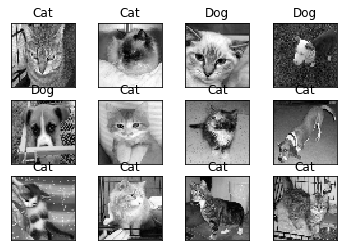

In [29]:
for num,data in enumerate(test_data[12:24]):
    img_num=data[1]
    img_data=data[0]
    
    y3=fig3.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    
    model_out=model.predict([data])[0]
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
    
    y3.imshow(orig,cmap='gray')
    plt.title(str_label)
    
    y3.axes.get_xaxis().set_visible(False)
    y3.axes.get_yaxis().set_visible(False)
plt.show()

In [30]:
with open("submission-file.csv","w") as f:
    f.write('id,label\n')

In [31]:
with open("submission-file.csv","a") as f:
    for data in tqdm(test_data):
        img_data = data[0]
        img_num = data[1]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))
        

100%|██████████| 12500/12500 [00:33<00:00, 372.02it/s]
